In [1]:
# imports
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as VF
from torchvision import models, transforms
from torch.utils.data import TensorDataset, DataLoader

from fastai.vision.gan import basic_generator, gan_critic
from fastai.torch_core import requires_grad, children
from fastai.callbacks import hook_outputs

from models import Generator

In [2]:
#load data into memory
data = np.load('brushstroke_data/' + 'episodes_42.npz')
stroke_data = data['strokes']

# define batch size
batch_size = 256

# define dataloaders and dataset used in training
actions = data['actions']
actions = torch.stack([torch.from_numpy(action).float() for action in actions])
strokes = torch.stack([torch.from_numpy(stroke).permute(2,0,1) for stroke in stroke_data])

# use generic pytorch datasets and dataloader classes
dataset = TensorDataset(strokes, actions)
dataloader = DataLoader(dataset, batch_size = 256, shuffle=False)

# define stroke transformer we will use during training
strokes_tfms = transforms.Compose([transforms.Lambda(lambda x: x.float()),
                                   transforms.Lambda(lambda x: x.div(255))
                                  ])

In [3]:
# list saved generator models 
!ls generator_models

brushstroke_gan_non_adversarial_generator_param.pth


In [4]:
condition_dim = 12
image_size = 64
fc_dim = int(image_size * image_size)
channels = 3
n_extra_layers = 1

# instaniate generator
generator = Generator(condition_dim=condition_dim,
                     fc_dim=fc_dim,
                     in_size=image_size,
                     n_channels=channels,
                     n_extra_layers=n_extra_layers)

# load saved generator parameters

root = "generator_models/"
generator.load_state_dict(torch.load(root + "brushstroke_gan_non_adversarial_generator_param.pth"))

# freeze generator parameters b/c only critic is being trained (non_adversarial)
for param in generator.parameters():
    generator.requires_grad = False

generator.eval()

Generator(
  (fc): Linear(in_features=12, out_features=4096, bias=True)
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(4096, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(64, eps=1e-05, m

In [5]:
# use GAN critic from fastai
critic = gan_critic(nf=64)

# visualize critic layers
critic

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (1): Dropout2d(p=0.075)
  (2): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace)
      )
      (2): MergeLayer()
    )
  )
  (3): Dropout2d(p=0.15)
  (4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): SelfAttention(
      (query): Conv1d(256, 32, kernel_size=(1,), stride=(1,), bias=False)
      (key): Conv1d(256, 32, kernel_size=(1,), stride=(1,), bias=False)
      (value): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False

In [6]:
# define learning rate
learning_rate = .003

# define loss and optimizer for critic
critic_optimizer = optim.Adam(critic.parameters(), lr=learning_rate, betas=(0.5, 0.999))
critic_loss = F.binary_cross_entropy

In [7]:
# define save directories for critic
root = 'critic_models/'
model = 'brushstroke_gan_non_adversarial_critic_param.pth'

if not os.path.isdir(root):
    os.mkdir(root)

Device : cuda
Starting Critic Training
epoch 1
epoch 1/10 | 1/391 complete!
loss: 0.7008219957351685
real brushstroke
critic pred: 0.4733350872993469 real (true=1)


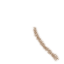

generated brushstroke
critic pred:  0.48162317276000977 generated (true=0)


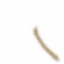

---
epoch 1/10 | 51/391 complete!
loss: 0.9760778546333313
real brushstroke
critic pred: 0.5040008425712585 real (true=1)


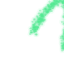

generated brushstroke
critic pred:  0.5022018551826477 generated (true=0)


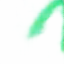

---
epoch 1/10 | 101/391 complete!
loss: 0.8357899785041809
real brushstroke
critic pred: 0.5101078748703003 real (true=1)


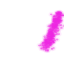

generated brushstroke
critic pred:  0.5180547833442688 generated (true=0)


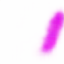

---
epoch 1/10 | 151/391 complete!
loss: 0.7883654236793518
real brushstroke
critic pred: 0.49192118644714355 real (true=1)


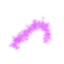

generated brushstroke
critic pred:  0.5047460794448853 generated (true=0)


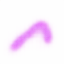

---
epoch 1/10 | 201/391 complete!
loss: 0.7645568251609802
real brushstroke
critic pred: 0.49807339906692505 real (true=1)


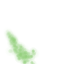

generated brushstroke
critic pred:  0.4890056252479553 generated (true=0)


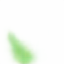

---
epoch 1/10 | 251/391 complete!
loss: 0.7502272129058838
real brushstroke
critic pred: 0.4914110600948334 real (true=1)


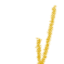

generated brushstroke
critic pred:  0.4792466163635254 generated (true=0)


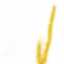

---
epoch 1/10 | 301/391 complete!
loss: 0.7403264045715332
real brushstroke
critic pred: 0.5216895937919617 real (true=1)


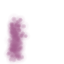

generated brushstroke
critic pred:  0.5303434133529663 generated (true=0)


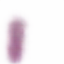

---
epoch 1/10 | 351/391 complete!
loss: 0.733789324760437
real brushstroke
critic pred: 0.5263510942459106 real (true=1)


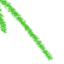

generated brushstroke
critic pred:  0.5185268521308899 generated (true=0)


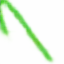

---
epoch 2
epoch 2/10 | 1/391 complete!
loss: 0.7293937802314758
real brushstroke
critic pred: 0.4770185649394989 real (true=1)


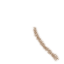

generated brushstroke
critic pred:  0.477898508310318 generated (true=0)


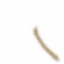

---
epoch 2/10 | 51/391 complete!
loss: 0.7250416874885559
real brushstroke
critic pred: 0.5115974545478821 real (true=1)


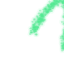

generated brushstroke
critic pred:  0.5195021033287048 generated (true=0)


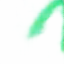

---
epoch 2/10 | 101/391 complete!
loss: 0.7215544581413269
real brushstroke
critic pred: 0.5066300630569458 real (true=1)


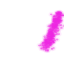

generated brushstroke
critic pred:  0.5160562992095947 generated (true=0)


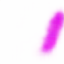

---
epoch 2/10 | 151/391 complete!
loss: 0.7186278700828552
real brushstroke
critic pred: 0.5239755511283875 real (true=1)


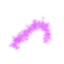

generated brushstroke
critic pred:  0.5274662375450134 generated (true=0)


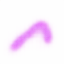

---
epoch 2/10 | 201/391 complete!
loss: 0.7164965271949768
real brushstroke
critic pred: 0.5043798685073853 real (true=1)


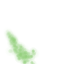

generated brushstroke
critic pred:  0.5032220482826233 generated (true=0)


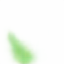

---
epoch 2/10 | 251/391 complete!
loss: 0.7144304513931274
real brushstroke
critic pred: 0.495720773935318 real (true=1)


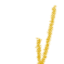

generated brushstroke
critic pred:  0.49087804555892944 generated (true=0)


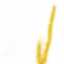

---
epoch 2/10 | 301/391 complete!
loss: 0.7126544713973999
real brushstroke
critic pred: 0.5043551325798035 real (true=1)


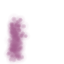

generated brushstroke
critic pred:  0.5100871324539185 generated (true=0)


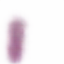

---
epoch 2/10 | 351/391 complete!
loss: 0.7110844850540161
real brushstroke
critic pred: 0.5038442611694336 real (true=1)


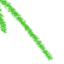

generated brushstroke
critic pred:  0.5038721561431885 generated (true=0)


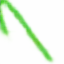

---
epoch 3
epoch 3/10 | 1/391 complete!
loss: 0.7099072337150574
real brushstroke
critic pred: 0.5309113264083862 real (true=1)


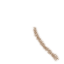

generated brushstroke
critic pred:  0.5289492607116699 generated (true=0)


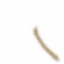

---
epoch 3/10 | 51/391 complete!
loss: 0.708624005317688
real brushstroke
critic pred: 0.5008218288421631 real (true=1)


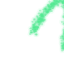

generated brushstroke
critic pred:  0.4713450074195862 generated (true=0)


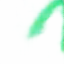

---
epoch 3/10 | 101/391 complete!
loss: 0.7077675461769104
real brushstroke
critic pred: 0.5016942620277405 real (true=1)


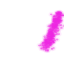

generated brushstroke
critic pred:  0.5002996921539307 generated (true=0)


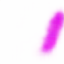

---
epoch 3/10 | 151/391 complete!
loss: 0.7069870233535767
real brushstroke
critic pred: 0.4912271797657013 real (true=1)


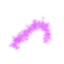

generated brushstroke
critic pred:  0.4978748559951782 generated (true=0)


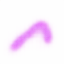

---
epoch 3/10 | 201/391 complete!
loss: 0.7062785625457764
real brushstroke
critic pred: 0.4965284466743469 real (true=1)


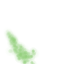

generated brushstroke
critic pred:  0.5177174806594849 generated (true=0)


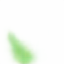

---
epoch 3/10 | 251/391 complete!
loss: 0.7056199908256531
real brushstroke
critic pred: 0.5122334957122803 real (true=1)


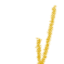

generated brushstroke
critic pred:  0.49037501215934753 generated (true=0)


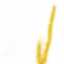

---
epoch 3/10 | 301/391 complete!
loss: 0.7050051093101501
real brushstroke
critic pred: 0.5226713418960571 real (true=1)


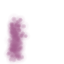

generated brushstroke
critic pred:  0.5101490616798401 generated (true=0)


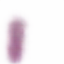

---
epoch 3/10 | 351/391 complete!
loss: 0.7044258713722229
real brushstroke
critic pred: 0.5008740425109863 real (true=1)


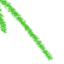

generated brushstroke
critic pred:  0.5056237578392029 generated (true=0)


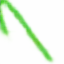

---
epoch 4
epoch 4/10 | 1/391 complete!
loss: 0.703940212726593
real brushstroke
critic pred: 0.49283987283706665 real (true=1)


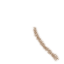

generated brushstroke
critic pred:  0.49886906147003174 generated (true=0)


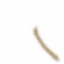

---
epoch 4/10 | 51/391 complete!
loss: 0.7033503651618958
real brushstroke
critic pred: 0.47320911288261414 real (true=1)


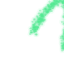

generated brushstroke
critic pred:  0.4260135591030121 generated (true=0)


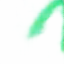

---
epoch 4/10 | 101/391 complete!
loss: 0.7027871608734131
real brushstroke
critic pred: 0.5287368297576904 real (true=1)


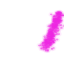

generated brushstroke
critic pred:  0.5514598488807678 generated (true=0)


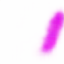

---
epoch 4/10 | 151/391 complete!
loss: 0.702231764793396
real brushstroke
critic pred: 0.5157672762870789 real (true=1)


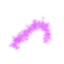

generated brushstroke
critic pred:  0.4899499714374542 generated (true=0)


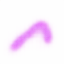

---
epoch 4/10 | 201/391 complete!
loss: 0.7017132043838501
real brushstroke
critic pred: 0.520184338092804 real (true=1)


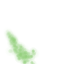

generated brushstroke
critic pred:  0.5085567235946655 generated (true=0)


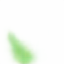

---
epoch 4/10 | 251/391 complete!
loss: 0.701202929019928
real brushstroke
critic pred: 0.5005078315734863 real (true=1)


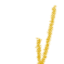

generated brushstroke
critic pred:  0.4832445979118347 generated (true=0)


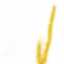

---
epoch 4/10 | 301/391 complete!
loss: 0.7007017135620117
real brushstroke
critic pred: 0.5279383063316345 real (true=1)


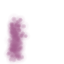

generated brushstroke
critic pred:  0.5186856985092163 generated (true=0)


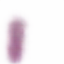

---
epoch 4/10 | 351/391 complete!
loss: 0.7002434730529785
real brushstroke
critic pred: 0.48339584469795227 real (true=1)


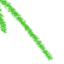

generated brushstroke
critic pred:  0.4458531141281128 generated (true=0)


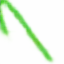

---
epoch 5
epoch 5/10 | 1/391 complete!
loss: 0.6998686194419861
real brushstroke
critic pred: 0.5446123480796814 real (true=1)


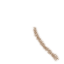

generated brushstroke
critic pred:  0.567221462726593 generated (true=0)


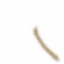

---
epoch 5/10 | 51/391 complete!
loss: 0.6996670961380005
real brushstroke
critic pred: 0.48666879534721375 real (true=1)


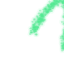

generated brushstroke
critic pred:  0.49310606718063354 generated (true=0)


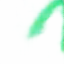

---
epoch 5/10 | 101/391 complete!
loss: 0.6994467377662659
real brushstroke
critic pred: 0.535942018032074 real (true=1)


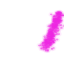

generated brushstroke
critic pred:  0.5642749071121216 generated (true=0)


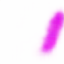

---
epoch 5/10 | 151/391 complete!
loss: 0.6992111802101135
real brushstroke
critic pred: 0.5341478586196899 real (true=1)


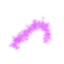

generated brushstroke
critic pred:  0.49940502643585205 generated (true=0)


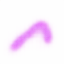

---
epoch 5/10 | 201/391 complete!
loss: 0.6989786028862
real brushstroke
critic pred: 0.5132489800453186 real (true=1)


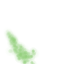

generated brushstroke
critic pred:  0.5294361710548401 generated (true=0)


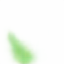

---
epoch 5/10 | 251/391 complete!
loss: 0.6987423896789551
real brushstroke
critic pred: 0.5056164860725403 real (true=1)


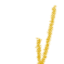

generated brushstroke
critic pred:  0.49281585216522217 generated (true=0)


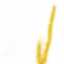

---
epoch 5/10 | 301/391 complete!
loss: 0.6985122561454773
real brushstroke
critic pred: 0.5067180395126343 real (true=1)


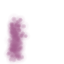

generated brushstroke
critic pred:  0.49409210681915283 generated (true=0)


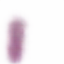

---
epoch 5/10 | 351/391 complete!
loss: 0.6982865333557129
real brushstroke
critic pred: 0.4918177127838135 real (true=1)


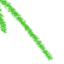

generated brushstroke
critic pred:  0.5110099911689758 generated (true=0)


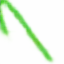

---
epoch 6
epoch 6/10 | 1/391 complete!
loss: 0.6981015205383301
real brushstroke
critic pred: 0.5022527575492859 real (true=1)


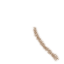

generated brushstroke
critic pred:  0.5080326795578003 generated (true=0)


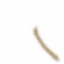

---
epoch 6/10 | 51/391 complete!
loss: 0.6984166502952576
real brushstroke
critic pred: 0.5017059445381165 real (true=1)


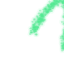

generated brushstroke
critic pred:  0.49919164180755615 generated (true=0)


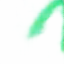

---
epoch 6/10 | 101/391 complete!
loss: 0.6982908844947815
real brushstroke
critic pred: 0.4980551302433014 real (true=1)


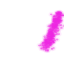

generated brushstroke
critic pred:  0.50108802318573 generated (true=0)


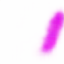

---
epoch 6/10 | 151/391 complete!
loss: 0.698169469833374
real brushstroke
critic pred: 0.5001162886619568 real (true=1)


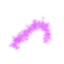

generated brushstroke
critic pred:  0.49844178557395935 generated (true=0)


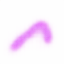

---
epoch 6/10 | 201/391 complete!
loss: 0.6980525255203247
real brushstroke
critic pred: 0.5008818507194519 real (true=1)


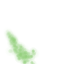

generated brushstroke
critic pred:  0.502119243144989 generated (true=0)


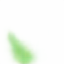

---
epoch 6/10 | 251/391 complete!
loss: 0.6979389786720276
real brushstroke
critic pred: 0.5012205243110657 real (true=1)


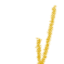

generated brushstroke
critic pred:  0.500099241733551 generated (true=0)


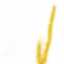

---
epoch 6/10 | 301/391 complete!
loss: 0.6978282332420349
real brushstroke
critic pred: 0.5017623901367188 real (true=1)


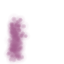

generated brushstroke
critic pred:  0.5015362501144409 generated (true=0)


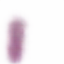

---
epoch 6/10 | 351/391 complete!
loss: 0.6977126002311707
real brushstroke
critic pred: 0.5060648918151855 real (true=1)


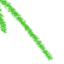

generated brushstroke
critic pred:  0.49655085802078247 generated (true=0)


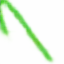

---
epoch 7
epoch 7/10 | 1/391 complete!
loss: 0.697609007358551
real brushstroke
critic pred: 0.4760947823524475 real (true=1)


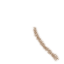

generated brushstroke
critic pred:  0.5204050540924072 generated (true=0)


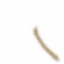

---
epoch 7/10 | 51/391 complete!
loss: 0.6974536180496216
real brushstroke
critic pred: 0.5215085744857788 real (true=1)


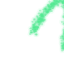

generated brushstroke
critic pred:  0.4693964421749115 generated (true=0)


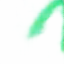

---
epoch 7/10 | 101/391 complete!
loss: 0.6972737908363342
real brushstroke
critic pred: 0.5435721278190613 real (true=1)


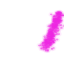

generated brushstroke
critic pred:  0.537359893321991 generated (true=0)


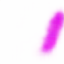

---
epoch 7/10 | 151/391 complete!
loss: 0.6970975399017334
real brushstroke
critic pred: 0.5299130082130432 real (true=1)


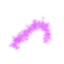

generated brushstroke
critic pred:  0.5339587926864624 generated (true=0)


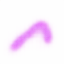

---
epoch 7/10 | 201/391 complete!
loss: 0.6969187259674072
real brushstroke
critic pred: 0.5151764750480652 real (true=1)


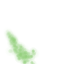

generated brushstroke
critic pred:  0.5164166688919067 generated (true=0)


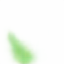

---
epoch 7/10 | 251/391 complete!
loss: 0.6967515349388123
real brushstroke
critic pred: 0.5040993094444275 real (true=1)


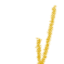

generated brushstroke
critic pred:  0.5290300250053406 generated (true=0)


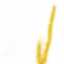

---
epoch 7/10 | 301/391 complete!
loss: 0.6965845823287964
real brushstroke
critic pred: 0.525806188583374 real (true=1)


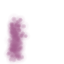

generated brushstroke
critic pred:  0.514825165271759 generated (true=0)


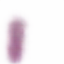

---
epoch 7/10 | 351/391 complete!
loss: 0.6964266896247864
real brushstroke
critic pred: 0.4295017123222351 real (true=1)


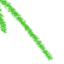

generated brushstroke
critic pred:  0.4662664830684662 generated (true=0)


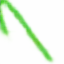

---
epoch 8
epoch 8/10 | 1/391 complete!
loss: 0.6962954998016357
real brushstroke
critic pred: 0.5438115000724792 real (true=1)


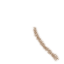

generated brushstroke
critic pred:  0.5470016002655029 generated (true=0)


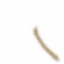

---
epoch 8/10 | 51/391 complete!
loss: 0.696133017539978
real brushstroke
critic pred: 0.5165281295776367 real (true=1)


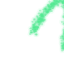

generated brushstroke
critic pred:  0.498916894197464 generated (true=0)


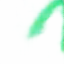

---
epoch 8/10 | 101/391 complete!
loss: 0.6959768533706665
real brushstroke
critic pred: 0.5365598201751709 real (true=1)


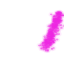

generated brushstroke
critic pred:  0.5359213948249817 generated (true=0)


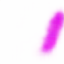

---
epoch 8/10 | 151/391 complete!
loss: 0.6958199143409729
real brushstroke
critic pred: 0.5367591381072998 real (true=1)


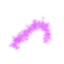

generated brushstroke
critic pred:  0.5367388129234314 generated (true=0)


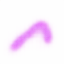

---
epoch 8/10 | 201/391 complete!
loss: 0.6956679821014404
real brushstroke
critic pred: 0.5403779745101929 real (true=1)


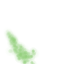

generated brushstroke
critic pred:  0.5153827667236328 generated (true=0)


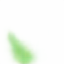

---
epoch 8/10 | 251/391 complete!
loss: 0.6955403089523315
real brushstroke
critic pred: 0.5132607817649841 real (true=1)


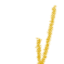

generated brushstroke
critic pred:  0.47001901268959045 generated (true=0)


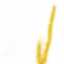

---
epoch 8/10 | 301/391 complete!
loss: 0.6953909993171692
real brushstroke
critic pred: 0.4913846254348755 real (true=1)


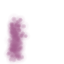

generated brushstroke
critic pred:  0.5198215842247009 generated (true=0)


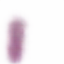

---
epoch 8/10 | 351/391 complete!
loss: 0.6952488422393799
real brushstroke
critic pred: 0.5140751600265503 real (true=1)


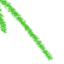

generated brushstroke
critic pred:  0.5052618384361267 generated (true=0)


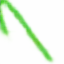

---
epoch 9
epoch 9/10 | 1/391 complete!
loss: 0.6951334476470947
real brushstroke
critic pred: 0.5505437850952148 real (true=1)


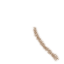

generated brushstroke
critic pred:  0.5443965196609497 generated (true=0)


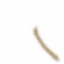

---
epoch 9/10 | 51/391 complete!
loss: 0.6949838995933533
real brushstroke
critic pred: 0.5229626893997192 real (true=1)


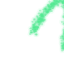

generated brushstroke
critic pred:  0.49433633685112 generated (true=0)


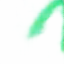

---
epoch 9/10 | 101/391 complete!
loss: 0.6948413252830505
real brushstroke
critic pred: 0.5501033067703247 real (true=1)


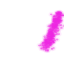

generated brushstroke
critic pred:  0.5175983905792236 generated (true=0)


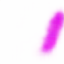

---
epoch 9/10 | 151/391 complete!
loss: 0.6947096586227417
real brushstroke
critic pred: 0.5607368350028992 real (true=1)


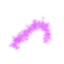

generated brushstroke
critic pred:  0.5609538555145264 generated (true=0)


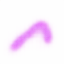

---
epoch 9/10 | 201/391 complete!
loss: 0.694577157497406
real brushstroke
critic pred: 0.4814015030860901 real (true=1)


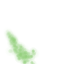

generated brushstroke
critic pred:  0.4512540102005005 generated (true=0)


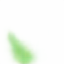

---
epoch 9/10 | 251/391 complete!
loss: 0.6944483518600464
real brushstroke
critic pred: 0.49021750688552856 real (true=1)


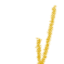

generated brushstroke
critic pred:  0.44945719838142395 generated (true=0)


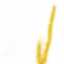

---
epoch 9/10 | 301/391 complete!
loss: 0.6943128108978271
real brushstroke
critic pred: 0.5315888524055481 real (true=1)


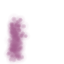

generated brushstroke
critic pred:  0.5181636214256287 generated (true=0)


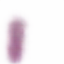

---
epoch 9/10 | 351/391 complete!
loss: 0.6942038536071777
real brushstroke
critic pred: 0.5166091322898865 real (true=1)


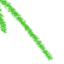

generated brushstroke
critic pred:  0.5264018177986145 generated (true=0)


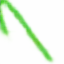

---
epoch 10
epoch 10/10 | 1/391 complete!
loss: 0.6941060423851013
real brushstroke
critic pred: 0.5517106652259827 real (true=1)


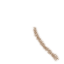

generated brushstroke
critic pred:  0.5367254614830017 generated (true=0)


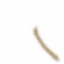

---
epoch 10/10 | 51/391 complete!
loss: 0.6939733028411865
real brushstroke
critic pred: 0.5233879685401917 real (true=1)


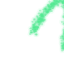

generated brushstroke
critic pred:  0.4986989498138428 generated (true=0)


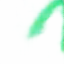

---
epoch 10/10 | 101/391 complete!
loss: 0.6938989758491516
real brushstroke
critic pred: 0.5221459865570068 real (true=1)


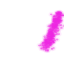

generated brushstroke
critic pred:  0.5241965651512146 generated (true=0)


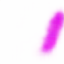

---
epoch 10/10 | 151/391 complete!
loss: 0.6937780976295471
real brushstroke
critic pred: 0.5495380163192749 real (true=1)


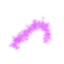

generated brushstroke
critic pred:  0.55462646484375 generated (true=0)


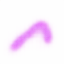

---
epoch 10/10 | 201/391 complete!
loss: 0.6936344504356384
real brushstroke
critic pred: 0.46421903371810913 real (true=1)


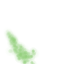

generated brushstroke
critic pred:  0.45297980308532715 generated (true=0)


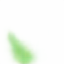

---
epoch 10/10 | 251/391 complete!
loss: 0.6935104727745056
real brushstroke
critic pred: 0.45321279764175415 real (true=1)


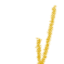

generated brushstroke
critic pred:  0.4561225473880768 generated (true=0)


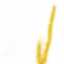

---
epoch 10/10 | 301/391 complete!
loss: 0.6933839917182922
real brushstroke
critic pred: 0.519661545753479 real (true=1)


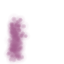

generated brushstroke
critic pred:  0.5026355385780334 generated (true=0)


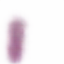

---
epoch 10/10 | 351/391 complete!
loss: 0.6932682394981384
real brushstroke
critic pred: 0.5538632869720459 real (true=1)


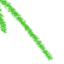

generated brushstroke
critic pred:  0.5582036972045898 generated (true=0)


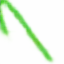

---
saving Critic ...
done.


In [8]:
# training
train_epoch = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device : {device}')

print('Starting Critic Training')

# move generator to device
generator.to(device)

# move critic to device
critic.to(device)

losses = []

for epoch in range(train_epoch):
    
    print(f'epoch {epoch + 1}')
    
    for num_iter, (stroke, action) in enumerate(dataloader):
        # move action and stroke to device
        action = action.to(device)
        stroke = torch.stack([strokes_tfms(s) for s in stroke]).to(device)
        
        batch_size = stroke.shape[0]
        
        # create ground truth matrices
        true_matrix = torch.ones((batch_size,1), dtype=torch.float, requires_grad = False).to(device)
        false_matrix = torch.zeros((batch_size, 1), dtype=torch.float, requires_grad = False).to(device)
        
        critic_optimizer.zero_grad()
        
        
        # compute true loss
        critic_true_predictions = torch.sigmoid(critic(stroke))
        critic_true_loss = critic_loss(critic_true_predictions, true_matrix)
        
        # compute generated loss
        generated_stroke = generator(action)
        critic_false_predictions = torch.sigmoid(critic(generated_stroke))
        critic_false_loss = critic_loss(critic_false_predictions, false_matrix)
        
        # average out losses 
        critic_training_loss = (critic_true_loss + critic_false_loss) / 2
        
        # step
        critic_training_loss.backward()
        critic_optimizer.step()
        
        losses.append(critic_training_loss.data.item())
         
        # print training info & display some examples    
        if (num_iter % 50) == 0:
            print(f'epoch {epoch+1}/{train_epoch} | {num_iter+1}/{len(dataloader)} complete!')
            print(f'loss: {torch.mean(torch.FloatTensor(losses))}')
            # display real brushstroke pred
            s = stroke[0].clone().cpu()
            print('real brushstroke')
            print('critic pred:', critic_true_predictions[0].item(), 'real (true=1)')
            display(VF.to_pil_image(s))
            # display fake brushstroke pred
            g = generated_stroke[0].clone().cpu()
            print('generated brushstroke')
            print('critic pred: ', critic_false_predictions[0].item(), 'generated (true=0)')
            display(VF.to_pil_image(g))
            print('---')
# optional save model            
# print('saving Critic ...')
# torch.save(critic.state_dict(), root + model)        
# print('done.')

In [9]:
# check if model saved properly
!ls critic_models

brushstroke_gan_non_adversarial_critic_param.pth
